# Logistic Regression: IMDB Review Sentiment Prediction

### Introduction

Given a review, we will try to predict wether it is positive or negative. To do this, we will make use of the model Logistic Regression with gradient descent. Further, we will investigate optimal values for different hyper-parameters (sample size, learning rate) and also methods of determining the top 10 most positive and negative words. Lastly, we will apply Simple Linear Regression as well to see if we can predict exact ratings.

# Dataset

This dataset provided by Stanford University is a set of files that contain IMDB reviews of movies, accompanied by their rating scores appended to the filenames. There is also a vocabulary file provided which is a list of English words that are mentioned.

First we will count the words in each review and take as feature the ones that are also in the vocabulary. This will turn out to be too large, so we will filter out words based on their co-variance with respect to the review ratings.

After picking features with absolute co-variances greater than a reasonable threshold, we will feed the dataset into our logistic regression model and predict the label of each sample, which in this case refers to if the review is positive or negative.

### To Download and Unzip the Dataset:

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [ ]:
import tarfile

file = tarfile.open('aclImdb_v1.tar.gz')
file.extractall()
file.close()

## Data Pre-Processing

In [1]:
import csv
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy
import statistics
import string
import time
import os

### Some helpers

In [2]:
_ROOT_DIR = './aclImdb/{type_of_data}/{type_of_review}'

def get_filenames(type_of_data):
    review_filenames = []
    review_ratings = []
    types_of_review = ['pos', 'neg']

    for type_of_review in types_of_review:
        cur_dir = _ROOT_DIR.format(type_of_data=type_of_data, type_of_review=type_of_review)

        for review in os.listdir(cur_dir):
            review_path = os.path.join(cur_dir, review)
            review_filenames.append(review_path)
            review_ratings.append(review.split('_')[1].split('.')[0])

    return review_filenames, review_ratings

In [3]:
def print_random(a_list, n):
    for i in range(0,n):
        print(a_list[random.randint(0,len(a_list)-1)])

### Reading the data

In [4]:
all_words = []
with open('aclImdb/imdb.vocab', newline='') as f:
    reader = csv.reader(f, delimiter='\n')
    for row in reader:
        all_words.append(row[0])

print(f"In total we have {len(all_words)} words in our vocabulary.")

In total we have 89527 words in our vocabulary.


In [5]:
train_filenames, train_ratings = get_filenames('train')
test_filenames, test_ratings = get_filenames('test')

print(f"And a total of {len(train_filenames)} reviews in both our training set and our testing set.")

And a total of 25000 reviews in both our training set and our testing set.


### Vectorizing the Data

We will use the sklearn Count Vectorizer in order to efficiently count the occurrence of our features in the reviews. While doing this, we will also filter out 'stop-words', ie words that appear too frequently (like 'the', 'I' or 'by'); as well as too rarely (like 'frogmarched', 'mantegna' or 'ninos').

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

max_df = 0.5
min_df = 0.01

train_count_vectorizer = CountVectorizer(input="filename", max_df = max_df, min_df = min_df)
x_train = train_count_vectorizer.fit_transform(train_filenames)

test_count_vectorizer = CountVectorizer(input="filename")
x_test = test_count_vectorizer.fit_transform(test_filenames)

In [7]:
print(f"We have removed {len(train_count_vectorizer.stop_words_)} words. A few of which are:")
print()
print_random(list(train_count_vectorizer.stop_words_), 5)

We have removed 73069 words. A few of which are:

wisconsin
cutouts
envelopes
zed
solicits


In [8]:
feature_names = train_count_vectorizer.get_feature_names_out()
print(f"Effectively reducing the number of words to {len(feature_names)}, which is still more than we'd like.")
print()
print_random(feature_names, 5)

Effectively reducing the number of words to 1780, which is still more than we'd like.

yes
ugly
experience
gotten
can


In [9]:
# Convert sparse array to np array and then to dataframe
x_train_df = pd.DataFrame(x_train.toarray())
x_test_df = pd.DataFrame(x_test.toarray())

# Name the columns appropriately
x_train_df.columns = train_count_vectorizer.get_feature_names_out()
x_test_df.columns = test_count_vectorizer.get_feature_names_out()

# Remove features that don't appear in our vocabulary
x_train_df = x_train_df[x_train_df.columns.intersection(all_words)]

# Make everything numeric
x_train_df = x_train_df.apply(pd.to_numeric)
x_test_df = x_test_df.apply(pd.to_numeric)

x_train_df

,ability,able,about,above,absolute,absolutely,absurd,academy,accent,accept,...,yes,yet,york,young,younger,your,yourself,zero,zombie,zombies
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
24996,0,0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24997,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24998,0,0,3,0,0,0,2,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
# Get labels
y_train_df = pd.DataFrame(train_ratings)
y_train_df.columns = ['ratings_numeric']
y_train_df = y_train_df.apply(pd.to_numeric)

y_test_df = pd.DataFrame(test_ratings)
y_test_df.columns = ['ratings_numeric']
y_test_df = y_train_df.apply(pd.to_numeric)
y_test_df

,ratings_numeric
0,9
1,8
2,7
3,8
4,10
...,...
24995,3
24996,4
24997,1
24998,3


## Feature Selection by Co-Variance

### Procedure

First we center and normalize every feature vector $x_f$, as well as the label vector $y$.
This is done by subtracting each row of the vector from the feature-wise mean (centralization) and then dividing with the standard deviation (normalization):

$$
x_f = \frac{(x_i) - \mu_f}{\sigma_f}
$$

And finally we obtain the co-variance for each feature $z_f$ by taking the dot product of the feature vector with the label vector and dividing it by the square root of the number of rows:

$$z_f=\frac{x_f \cdot y}{\sqrt{N}}$$

This number will be an indication of how impactful a given feature is.

### Implementation

In [11]:
def standardize(col):
    mean = sum(col) / len(col)
    std_dev = np.std(col)
    result = col.apply(lambda x: (x - mean)/std_dev)
    return result

def co_var(x, y):
    x, y = standardize(x), standardize(y)
    mult = lambda x,y: x*y
    return sum(mult(x,y)) / math.sqrt(len(x))

co_vars = []
for col in x_train_df.columns:
    co_vars.append(co_var(x_train_df[col], y_train_df.iloc[:,0]))

co_vars[:5]

[-0.8117230979385626,
 4.813759576498695,
 -4.177930600542044,
 2.5188772688828243,
 -2.1732319642401596]

In [12]:
abs_co_vars = [abs(ele) for ele in co_vars]
print(f"Description of our absolute z-scores:")
print()
print(f"Mean: {statistics.mean(abs_co_vars)}")
print(f"Std: {np.std(abs_co_vars)}")
print(f"Med: {statistics.median(abs_co_vars)}")

Description of our absolute z-scores:

Mean: 4.585871993213389
Std: 4.42627788641568
Med: 3.4269158336349332


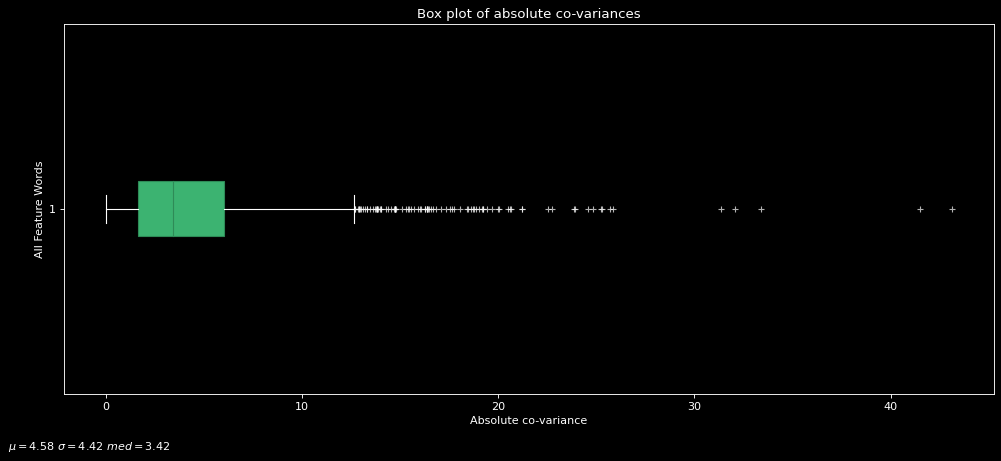

In [13]:
plt.style.use('dark_background')
plt.figure(num=1, figsize=(15, 6), dpi=80)
plt.boxplot(abs_co_vars, vert=False, patch_artist = True,
            boxprops={'color': 'seagreen', 'facecolor': 'mediumseagreen'},
            medianprops={'color': 'seagreen'},
            flierprops={'marker': '+', 'markersize': 5, 'markerfacecolor': 'mediumseagreen', 'alpha':0.7})
plt.xlabel('Absolute co-variance')
plt.ylabel('All Feature Words')
plt.title('Box plot of absolute co-variances')
plt.text(-5, 0.35, r'$\mu=4.58\ \sigma=4.42\ med=3.42$')
plt.grid(color='black', linestyle='-', linewidth=0.5, alpha=0.5)

plt.show()

### Evaluation of High Co-Variance Features

As mentioned before, this numerical value we found is a description of how a particular word is correlated with the rating and more generally viewer sentiment. This claim can be verified quite clearly by observing the words which have high absolute co-variance.

In [14]:
co_var_df = pd.DataFrame(co_vars, x_train_df.columns)
co_var_df.columns = ['co-variance']
co_var_df_sorted = co_var_df.sort_values('co-variance')

Now we look at the feature words with most positive and most negative z-score and verify our hypothesis that this correlates with sentiment the word implies.

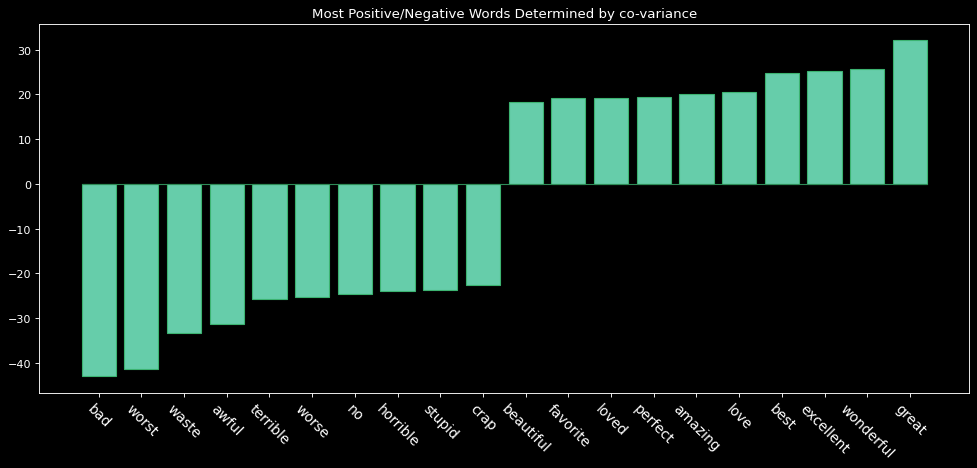

In [15]:
top_co_var_df = pd.concat([co_var_df_sorted.iloc[:10,:], co_var_df_sorted.iloc[-10:,:]], axis=0)

plt.figure(num=1, figsize=(15, 6), dpi=80)
plt.bar(top_co_var_df.index.values, top_co_var_df['co-variance'], color ='mediumaquamarine', edgecolor='mediumseagreen')
plt.xticks(rotation = -45, fontsize=12.5)
plt.axhline(y=0,linewidth=1, xmin=0.046, xmax = 0.955, color='seagreen')

plt.title("Most Positive/Negative Words Determined by co-variance")
plt.show()

As is clearly seen, the data is consistent with our hypothesis.

### Final Touches

Now, we must choose a cut-off to filter feature words with. We have two choices: either pick an arbitrary number of positive numbers and the same number of negative numbers, or pick a threshold for absolute co-variance for inclusion.

Here we will focus on the importance of absolute co-variance and choose feature words solely on this. Of course we will make sure that this yields more or less a similar number of negative and positive features.

In [16]:
features = co_var_df[abs(co_var_df['co-variance']) > 7].index.to_list()

print(f"We've ended up with {len(features)} features.")
print()
print_random(features, 5)

We've ended up with 347 features.

god
ever
available
throw
wasn


In [17]:
num_neg_feature = (co_var_df.loc[features,:] < 0).sum().values[0]
print(f"We have chosen {num_neg_feature} negative words and {len(features) - num_neg_feature} positive words.")

We have chosen 196 negative words and 151 positive words.


In [18]:
x_train_df = x_train_df[x_train_df.columns.intersection(features)]
x_test_df = x_test_df[x_test_df.columns.intersection(features)]

As we're looking to make a binary classification, we will also keep a column of binary labels for ratings.

In [19]:
y_train_df['ratings'] = [1 if x > 5 else 0 for x in y_train_df['ratings_numeric']]
y_test_df['ratings'] = [1 if x > 5 else 0 for x in y_test_df['ratings_numeric']]

In [20]:
y_train_df

,ratings_numeric,ratings
0,9,1
1,8,1
2,7,1
3,8,1
4,10,1
...,...,...
24995,3,0
24996,4,0
24997,1,0
24998,3,0


We noticed a bias stemmed from the way we extract the data: the first half of the data points are positive whereas the last half will be negative. We resolve this bias by shuffling. We also fix the random state to 42, the so called ["answer to the ultimate question in life"](https://en.wikipedia.org/wiki/42_(number)#The_Hitchhiker's_Guide_to_the_Galaxy), so as to ensure reproducability.

In [21]:
df_train = pd.concat([x_train_df, y_train_df], axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
df_test = pd.concat([x_train_df, y_test_df], axis=1).sample(frac=1,random_state=42).reset_index(drop=True)

Lastly, we convert the pandas dataframes for input data into scipy sparse matrices and labels into one-dimensional numpy arrays. We will also keep a set of regular numpy array inputs and numeric labels, for further experimentation with Linear Regression

In [22]:
x_train = df_train.iloc[:,:-2].to_numpy()
x_test = df_test.iloc[:,:-2].to_numpy()

# We will use sparse matrices as they're more optimized for the type of data we're working with
x_train_sparse = scipy.sparse.csr_matrix(x_train)
x_test_sparse = scipy.sparse.csr_matrix(x_test)

y_train = df_train.loc[:,'ratings'].values.flatten()
y_test = df_test.loc[:,'ratings'].values.flatten()

y_train_numeric = df_train.loc[:,'ratings_numeric'].values.flatten()
y_test_numeric = df_test.loc[:,'ratings_numeric'].values.flatten()

In [23]:
x_train.shape

(25000, 347)

In [24]:
y_train.shape

(25000,)

### Sparse Matrices

Why use scipy sparse matrices instead of the regular numpy ndarray?

The csr matrices are optimized for the type of data we have, where most data points in the matrix are 0. Instead of storing the value in every coordinate $(i,j)$, they are simply a list of $(i,j,val)$ entries, storing only the coordinates where there is a non-zero value. Thus these objects are both more memory efficient as well as faster. In fact, our benchmarking results show that the sparse matrices can perform up to 2x faster for our purposes.

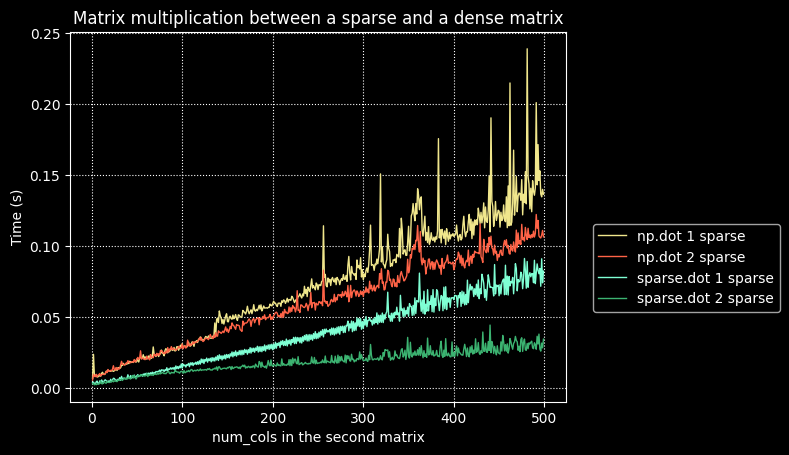

In [25]:
time_map = dict()
time_map['1_sparse'] = dict()
time_map['2_sparse'] = dict()

time_map['1_sparse']['np'] = []
time_map['2_sparse']['np'] = []
time_map['1_sparse']['sp'] = []
time_map['2_sparse']['sp'] = []

np.random.seed(42)
range_col = range(1, 500)

for col in range_col:
    x_np = np.random.rand(x_train.shape[1], col)
    x_sp_sparse = scipy.sparse.random(x_train.shape[1], col, random_state=42)
    
    # We prepare our sparse matrix in regular format so that conversions don't affect time
    x_sp_regular = x_sp_sparse.toarray()
    
    
    # 1 sparse np
    start = time.time()
    np.dot(x_train, x_np)
    end = time.time()
    time_map['1_sparse']['np'].append(end - start)
    
    
    # 2 sparse np
    start = time.time()
    np.dot(x_train, x_sp_regular)
    end = time.time()
    time_map['2_sparse']['np'].append(end - start)
    
    
    # 1 sparse sp
    start = time.time()
    x_train_sparse.dot(x_np)
    end = time.time()
    time_map['1_sparse']['sp'].append(end - start)
    
    # 2 sparse sp
    start = time.time()
    x_train_sparse.dot(x_sp_sparse)
    end = time.time()
    time_map['2_sparse']['sp'].append(end - start)

plt.plot(range_col, time_map['1_sparse']['np'], label="np.dot 1 sparse", color='khaki', linewidth=1)
plt.plot(range_col, time_map['2_sparse']['np'], label="np.dot 2 sparse", color='tomato', linewidth=1)

plt.plot(range_col, time_map['1_sparse']['sp'], label="sparse.dot 1 sparse", color='aquamarine', linewidth=1)
plt.plot(range_col, time_map['2_sparse']['sp'], label="sparse.dot 2 sparse", color='mediumseagreen', linewidth=1)

plt.ylabel("Time (s)")
plt.xlabel("num_cols in the second matrix")
plt.title("Matrix multiplication between a sparse and a dense matrix")
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
plt.grid(True, linestyle="dotted")
plt.show()

We see that, although there are spikes, sparse.dot consistently performs better than np.dot when there's at least one sparse matrix involved. Further, if we have two sparse matrices, the np.dot performance is not different from the case where we have one dense and one sparse, whereas sparse.dot is even faster.

For our purposes, the case that matters is 1 sparse, as we will be multiplying input sparse matrix x with the weights vector. Although not as drastic as the 2 sparse case, there is still a time difference, which could cost perhaps several tens of minutes more of our time as well as computing power as we iterate thousands of times through our dataset.

# The model

### Logistic Regression

To predict wether a given review is good or bad, we implement Logistic Regression for binary classification with gradient descent optimization. In summary, this is Linear Regression but with a logistic basis function that maps the real output into the range $[0;1]$, which can be interpreted as class probability.

More detailed explanations of the model can be found in online sources such as [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression) or in textbooks such as [Murphy22](https://probml.github.io/pml-book/book1.html).

### Cost Function

Before anything, we need to choose a loss function to minimize: a function that describes how off our predictions are. Naturally, this function must be differentiable. Further, we want this function to be convex since a convex function will have a global minimum, which we can approximate better and better with each iteration of gradient descent.

A popular loss function that fits this criteria is Cross Entropy cost, which is what we will use:

$$
J(w) = \sum y ln\hspace{0.5mm}(\hat{y})+(1-y) \hspace{1mm}ln\hspace{0.5mm}(1-\hat{y})
$$

Where $\hat{y}\ $ is our prediction given a weight vector $\ w\ $ and an input vector $\ x\ $. This is the logistic function for $\ L\ = 1$, $x_0 = 0$ and $k=w$:

$$
    f(x) = \frac{L}{1+e^{-k(x-x_0)}}
    \hspace{10mm}
    \text{for}
    \hspace{10mm}
    L=1 \land x_0 = 0
    \hspace{10mm}
    \Longrightarrow
    \hspace{10mm}
    \hat{y} = \frac{1}{1+e^{-xw}}
$$

This function admits a neat partial derivative:

$$
\frac{\partial J(w)}{\partial w}
= (\hat{y} - y)x
$$

Of which we will make extensive use during gradient descent.

In [26]:
def cross_entropy_cost(x, y, w):
    N, D = x.shape                                                     
    a = x.dot(w)
    J = np.mean(y * np.log1p(np.exp(-a)) + (1-y) * np.log1p(np.exp(a)))
    return J

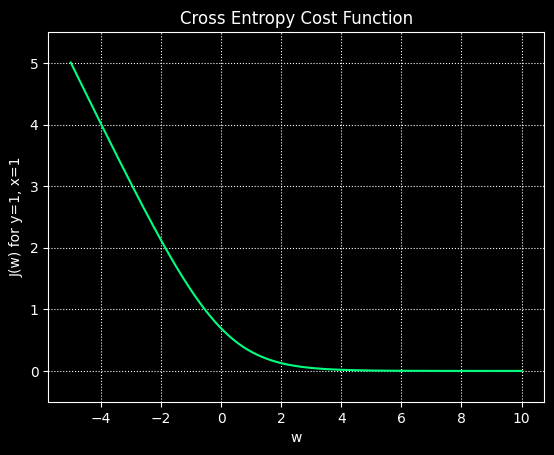

In [27]:
xw = np.linspace(-5,10,1000)
y_true = np.ones(len(xw))

p = 1/(1+np.exp(-xw))
ce = -y_true * np.log(p)

plt.clf()
plt.plot(xw, ce, "-", color='springgreen')
plt.xlabel("w")
plt.title("Cross Entropy Cost Function")
plt.ylabel("J(w) for y=1, x=1")
plt.ylim((-0.5,5.5))
plt.grid(True, linestyle="dotted")
plt.show()

### log1p vs log

One key thing to note here is the use of np.log1p instead of np.log, which for x really close to 0 is a far better approximation of $log(1+x)$ compared to np.log. See the below plot for the difference in behavior in question

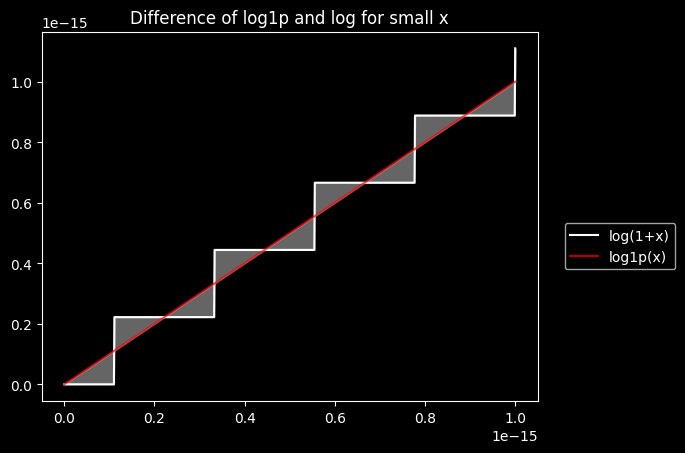

In [28]:
x = np.linspace(1e-125,1e-15,int(1e3))
plt.plot(x, np.log(1+x), color = 'white', label="log(1+x)")
plt.plot(x, np.log1p(x), color = 'red', label="log1p(x)", alpha=0.7)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
plt.fill_between(x, np.log(1+x), np.log1p(x), color='white', alpha=.4)
plt.title("Difference of log1p and log for small x")

plt.show()

We see that up until $(0.1)(1e-15)$ log faultily returns 0 whereas log1p outputs the correct answer. More generally, for small values of x it seems like the return value of log ressembles this step function wherease log1p is smooth.

### Gradient Descent

The implementation makes use of the gradient descent optimization method. We compute the partial derivative of the loss function with the respect to our weight vector to obtain the gradient. Further, at each iteration we adjust our weights according to the gradient until number of iterations reaches the maximum, which we chose to be $10^5$, or until the gradient is less than a constant set to $\epsilon = 10^{-5}$.

The gradient of the cross entropy cost is as follows:

$$
\nabla J 
= 
\begin{pmatrix} 
\frac{\partial J(w_{d_1})}{\partial w_{d_1}} \\  
... \\ 
\frac{\partial J(w_{d_N})}{\partial w_{d_N}} \\
\end{pmatrix}
\hspace{5mm}
\text{where}
\hspace{5mm}
\frac{\partial J(w_{d_i})}{\partial w_{d_i}}
= (\hat{y}_{d_i} - y_i)x_{d_i}
$$

After calculating the gradient, we multiply the gradient by our learning rate $\alpha = 0.6$ and subtract it from the vector of weights at iteration $t-1$ to get the weights of iteration $t$.

$$
w_t = w_{t-1} - \alpha \cdot \nabla J
\hspace{5mm}
\text{where}
\hspace{5mm}
w_t
=
\begin{pmatrix} 
w^{(f_1)}_t \\  
... \\ 
w_t^{f_D} \\
\end{pmatrix}
\hspace{3mm}
\text{at iteration}
\hspace{2mm}
t=\{0, 1, 2, ...\}
\hspace{5mm}
$$

The implementation can incorporate a bias term, which refers to an extra term $w_0$ that isn't associated with any of the features, appended to our vector of weights.

As $J(w)$ is a convex function, we can prove mathematically that as $t \rightarrow \infty$, our vector of weights $w$ will reach the global minimum, a value that minimizes the cross-entropy cost with respect to the weights. Our model operates under the hypothesis that the set of weights determined with this method will extend to unseen data, allowing us to make accurate predictions.

## Implementation

In [29]:
class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=.6, epsilon=1e-5, max_iters=1e5):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iters = max_iters
        self.historical_weights = []

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(x.dot(self.w))
        grad = x.transpose().dot(yh - y)/N
        return grad
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]

        if self.add_bias:
            N = x.shape[0]
            x = scipy.sparse.hstack([x, np.ones((N,1))])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        
        self.t = 0
        self.historical_weights.append(self.w)

        while np.linalg.norm(g) > self.epsilon and self.t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            self.historical_weights.append(self.w)

            self.t += 1
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        if self.add_bias:
            x = scipy.sparse.hstack([x, np.ones((N,1))])
        yh = logistic(x.dot(self.w))
        return yh
    
logistic = lambda z: 1./ (1 + np.exp(-z))

### Small Perturbation

Before performing experiments, let's verify if we are correctly computing the loss and gradient by using the method of small perturbation. Essentially, we approximate the change in loss based on a small change in $w$ using the limit definition of the derivative, and then compare it to our gradient calculation to see if they match.

For a given $w$, we have:

$$
\frac{\delta J}{\delta w}
=
\lim_{h\to 0} \frac {J(w + h) - J(w)}{h}
\approx
\frac{J(w + \epsilon) - J(w - \epsilon)}{2 \epsilon}
\hspace{5mm}
\text{where we choose}
\hspace{5mm}
\epsilon = \text{Unif}([0;1])\times10^{-5}
$$

Then we compare this value to the sum of our gradient vector. If they are produce different results, it means something is wrong and we need to re-evaluate our methods: however we will see that this is not the case. 

In [30]:
diffs = []
rng = np.flip(np.linspace(1e-11, 2, 50))

for epsilon in rng:
    dummy_model = LogisticRegression(add_bias = False)

    N,D = x_train.shape
    x = scipy.sparse.random(N,D)
    y = np.random.randint(2, size=(N,))
    w = np.random.randint(-2, high=3, size=(D,))

    w0 = w
    #epsilon = np.random.uniform() * 1e-5
    w1 = w0 + epsilon
    w2 = w0 - epsilon
    ce1 = cross_entropy_cost(x, y, w1)
    ce2 = cross_entropy_cost(x, y, w2)
    dw_num = (ce1 - ce2)/(2*epsilon) 

    dummy_model.w = w
    g = dummy_model.gradient(x, y)
    dw_cal = sum(g)

    diffs.append(dw_num - dw_cal)

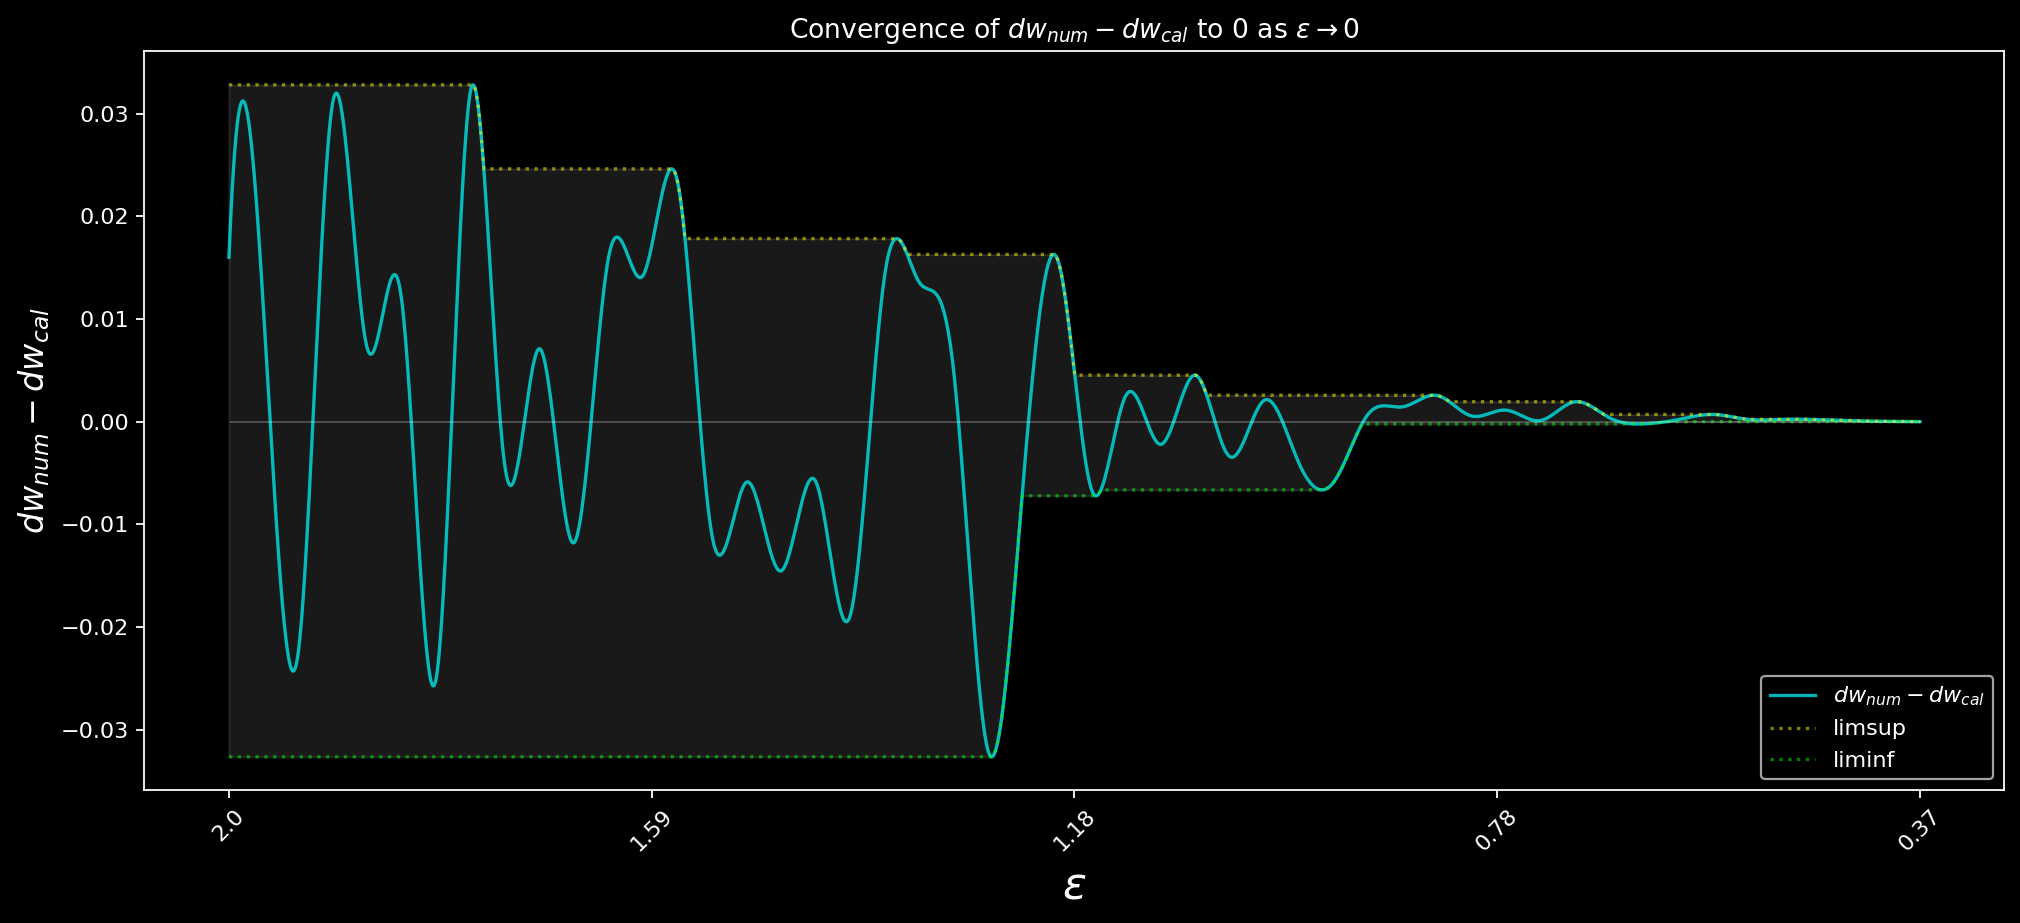

In [31]:
plt.figure(num=1, figsize=(15, 6), dpi=160)

# Smoothen diffs
spl = scipy.interpolate.make_interp_spline(np.linspace(0, len(diffs), len(rng)), diffs)
X_ = np.linspace(0, len(diffs), 10000)
diffs_new = spl(X_)

plt.plot(X_, diffs_new, color='aqua', label=r"$dw_{num} - dw_{cal}$", alpha=.7)

# Compute liminf and limsup by taking max/min of rest of array iteratively
limsups = np.maximum.accumulate(diffs_new[::-1])[::-1]
liminfs = np.minimum.accumulate(diffs_new[::-1])[::-1]

plt.plot(X_, limsups, label = "limsup", alpha = .5, color = 'yellow', linestyle='dotted')
plt.plot(X_, liminfs, label = "liminf", alpha = .5, color = 'lime', linestyle='dotted')
plt.fill_between(X_, limsups, liminfs, alpha=.1, color='white')


rng_rounded = [ round(elem, 2) for elem in rng ]
plt.xticks(ticks=np.linspace(0, len(rng), int(len(rng)/10)), labels=rng_rounded[0::10], rotation=45)

plt.title(r"Convergence of $dw_{num}-dw_{cal}$ to 0 as $\epsilon \rightarrow 0$")
plt.ylabel(r"$dw_{num}-dw_{cal}$", fontsize=15)
plt.xlabel(r"$\epsilon$", fontsize=20)
plt.axhline(y=0,linewidth=.2, xmin=0.046, xmax = 0.955, color='white')
plt.legend(loc="lower right")

plt.show()

We see that our calculated gradient is almost exactly equal to the theoretical gradient. We are satisfied with this result and can move on to experimentation

### Experimentation

Now it's time to run some experiments and measure our model's performance.

### Initial Experiment

In [32]:
start = time.time()
model = LogisticRegression()
model.fit(x_train_sparse, y_train)
end = time.time()
print("Model fit")
print(f"Time elapsed: {end - start}, iterations: {model.t}")

Model fit
Time elapsed: 49.14669108390808, iterations: 15008


In [33]:
# Train (we had already fit the model)
y_train_pred = model.predict(x_train_sparse)
y_train_pred = (y_train_pred > 0.5).astype(int)
acc_train = sum(y_train_pred==y_train)/len(y_train)

# Test
y_test_pred = model.predict(x_test_sparse)
y_test_pred = (y_test_pred > 0.5).astype(int)
acc_test = sum(y_test_pred==y_test)/len(y_test)

print(f"Train accuracy: {acc_train:.3f}; test accuracy: {acc_test:.3f}")

Train accuracy: 0.867; test accuracy: 0.867


Our initial experiment has yielded decent results. This doesn't mean we're done, though. We should examine if the model has converged to determine if increasing the learning rate or maximum iterations can potentially improve our results.

### CE vs time

Theoretically we should be seeing a decrease in loss in each iteration of gradient descent, until the model converges, in which case we should see a stabilization of loss around a certain value. Let's see if this is reflected in reality.

In [34]:
def plot_CE(self, x, y):
    N,D = x.shape
    if len(self.historical_weights[0]) > D: # this means there is a bias term
        x = scipy.sparse.hstack([x, np.ones((N,1))])
        
    x_iterable = itertools.repeat(x)
    y_iterable = itertools.repeat(y)
    
    costs = list(map(cross_entropy_cost, x_iterable, y_iterable, self.historical_weights))
    epochs = np.linspace(0, self.t + 1, self.t + 1) 
    
    plt.plot(epochs, costs)
    plt.xlabel("epochs")
    plt.ylabel("CE Cost")
    plt.text(17000, 0.575 , f"Total n_epochs: {self.t +1}")
    plt.text(17000, 0.555 , f"Min CE cost: {costs[self.t]:.3f}")
    plt.text(17000, 0.535 , f"Learning rate: {model.learning_rate}")
    plt.title("Cross-entropy cost as a function of time")
    plt.show()

LogisticRegression.plot_CE = plot_CE

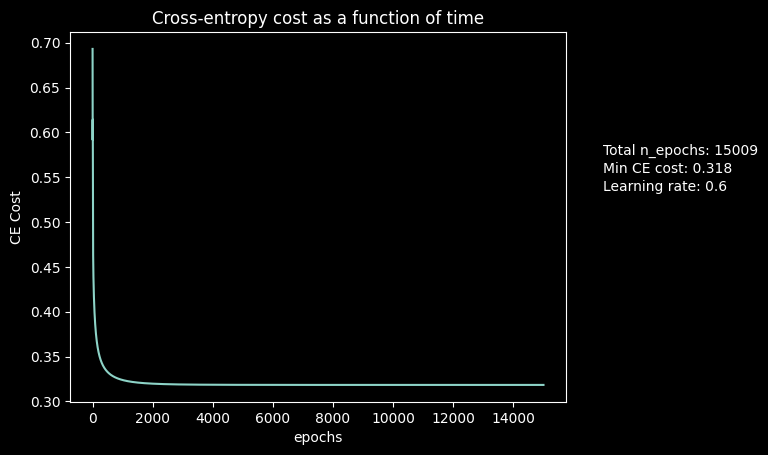

In [35]:
model.plot_CE(x_train_sparse, y_train)

It seems like the CE Cost has converged to $\approx3.2\ $ in around 15000 iterations. The stopping condition that's in play here is the threshold for the norm of the gradient, which is a measure of the magnitude of the gradient. As the model converges, this value drops lower and lower, eventually resulting in negligible changes in weights.

### Analysis of Weights

Let us now observe the weights of the converged model. These coefficients are a measure of how much a unit change in a given feature will affect our predictions. We hypothesize that these should indicate wether a feature word is positive or negative.

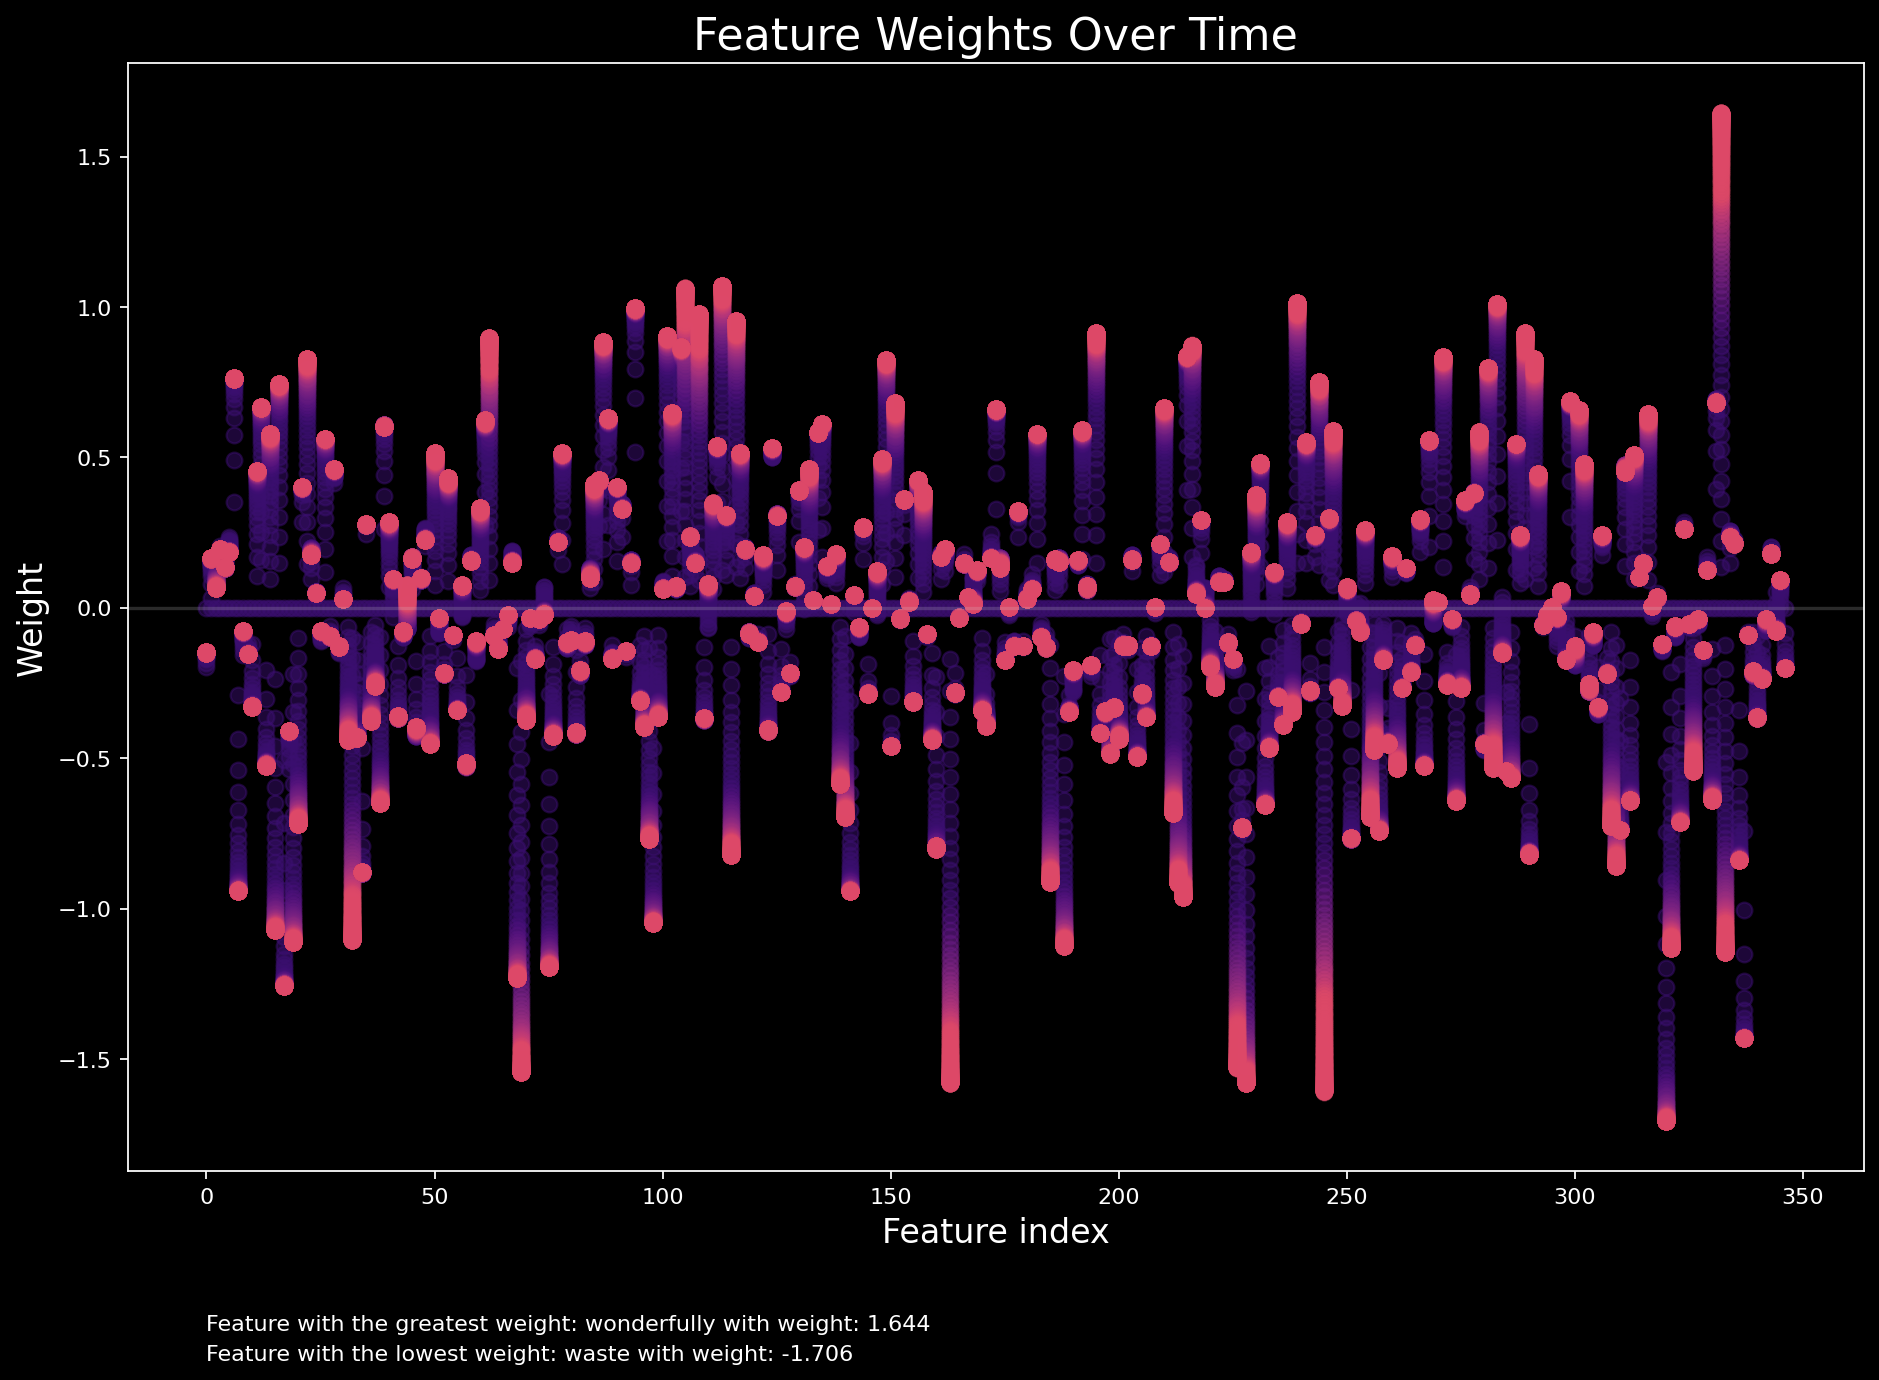

In [36]:
plt.figure(num=50, figsize=(14, 9), dpi=160)
for i in range(0, len(model.historical_weights), 100):
    weight_set = model.historical_weights[i]
    cmap = plt.cm.magma
    color = cmap(min(max(i*2/len(model.historical_weights), .2), .6))  
    plt.scatter(np.arange(0,len(x_train_df.columns)), weight_set[:-1], s=50,
                color = color, marker='o', alpha=.5)


plt.xlabel("Feature index", fontsize=15)
plt.ylabel("Weight", fontsize=15)
plt.title("Feature Weights Over Time", fontsize=20)
plt.axhline(0, color='lightgray', alpha = .2)
plt.text(0, -2.4, f"Feature with the greatest weight: {x_train_df.columns[np.argmax(model.w[:-1])]} with weight: {np.max(model.w[:-1]):.3f}")
plt.text(0, -2.5, f"Feature with the lowest weight: {x_train_df.columns[np.argmin(model.w[:-1])]} with weight: {np.min(model.w[:-1]):.3f}")

plt.show()
    

### Most Positive/Negative Words based on Weights

Now let's take a closer look at the features with the top and minimum weight values.

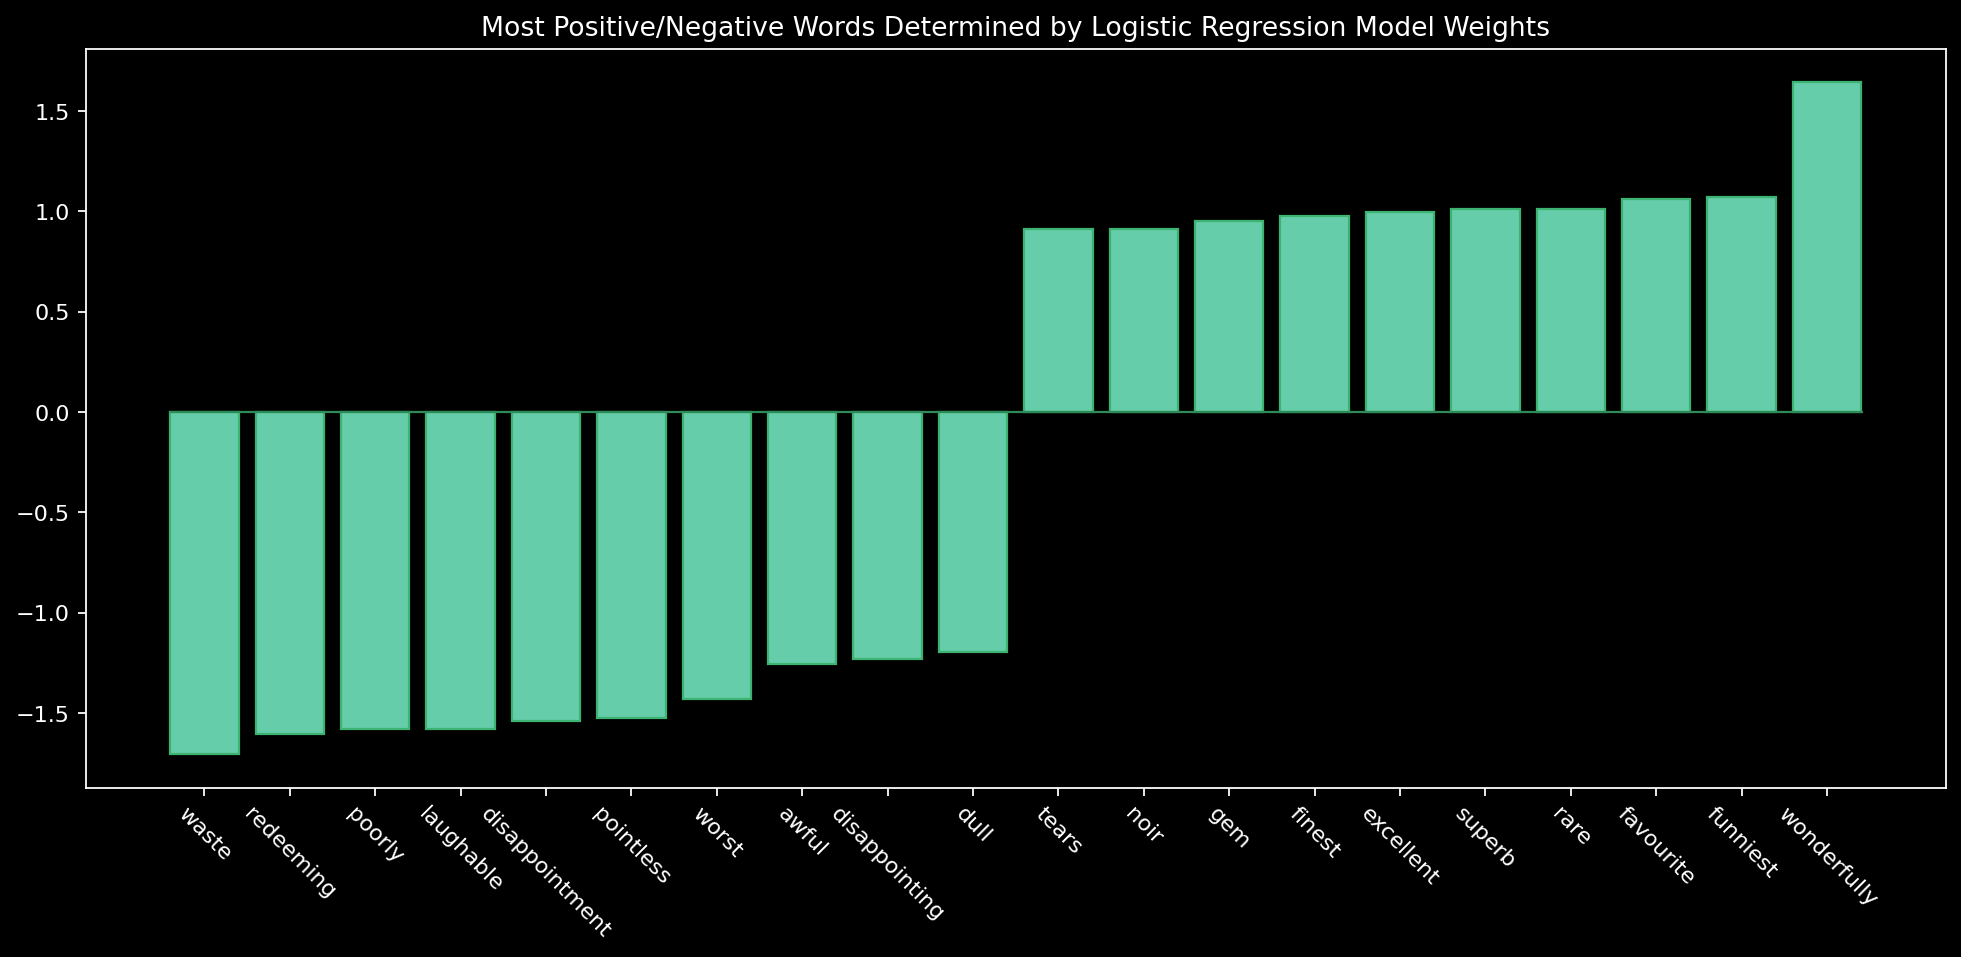

In [37]:
if model.add_bias:
    w_no_bias = model.w[:-1]
else:
    w_no_bias = model.w
    
weights_df = pd.DataFrame(data = {'weights': w_no_bias, 'feature': x_train_df.columns.values},
                          columns = ['weights', 'feature'])

top_weights_df = pd.concat([weights_df.sort_values('weights').iloc[:10,:],
                           weights_df.sort_values('weights').iloc[-10:,:]], axis=0)

plt.figure(num=1, figsize=(15, 6), dpi=160)
plt.bar(top_weights_df['feature'].values, top_weights_df['weights'], color ='mediumaquamarine', edgecolor='mediumseagreen')
plt.xticks(rotation = -45, fontsize=10)
plt.title("Most Positive/Negative Words Determined by Logistic Regression Model Weights")
plt.axhline(y=0,linewidth=1, xmin=0.046, xmax = 0.955, color='seagreen')
plt.show()

Comparing this to the previously generated bar plot with z-scores, we see that the z-scores and weights don't necessarily agree on all of the top most positive/negative words. That being said, the words chosen by both methods are clearly valid.

### Decision Boundries

We can also look at the decision boundaries of specific features to get a better sense of how they reflect the sentiment of the review

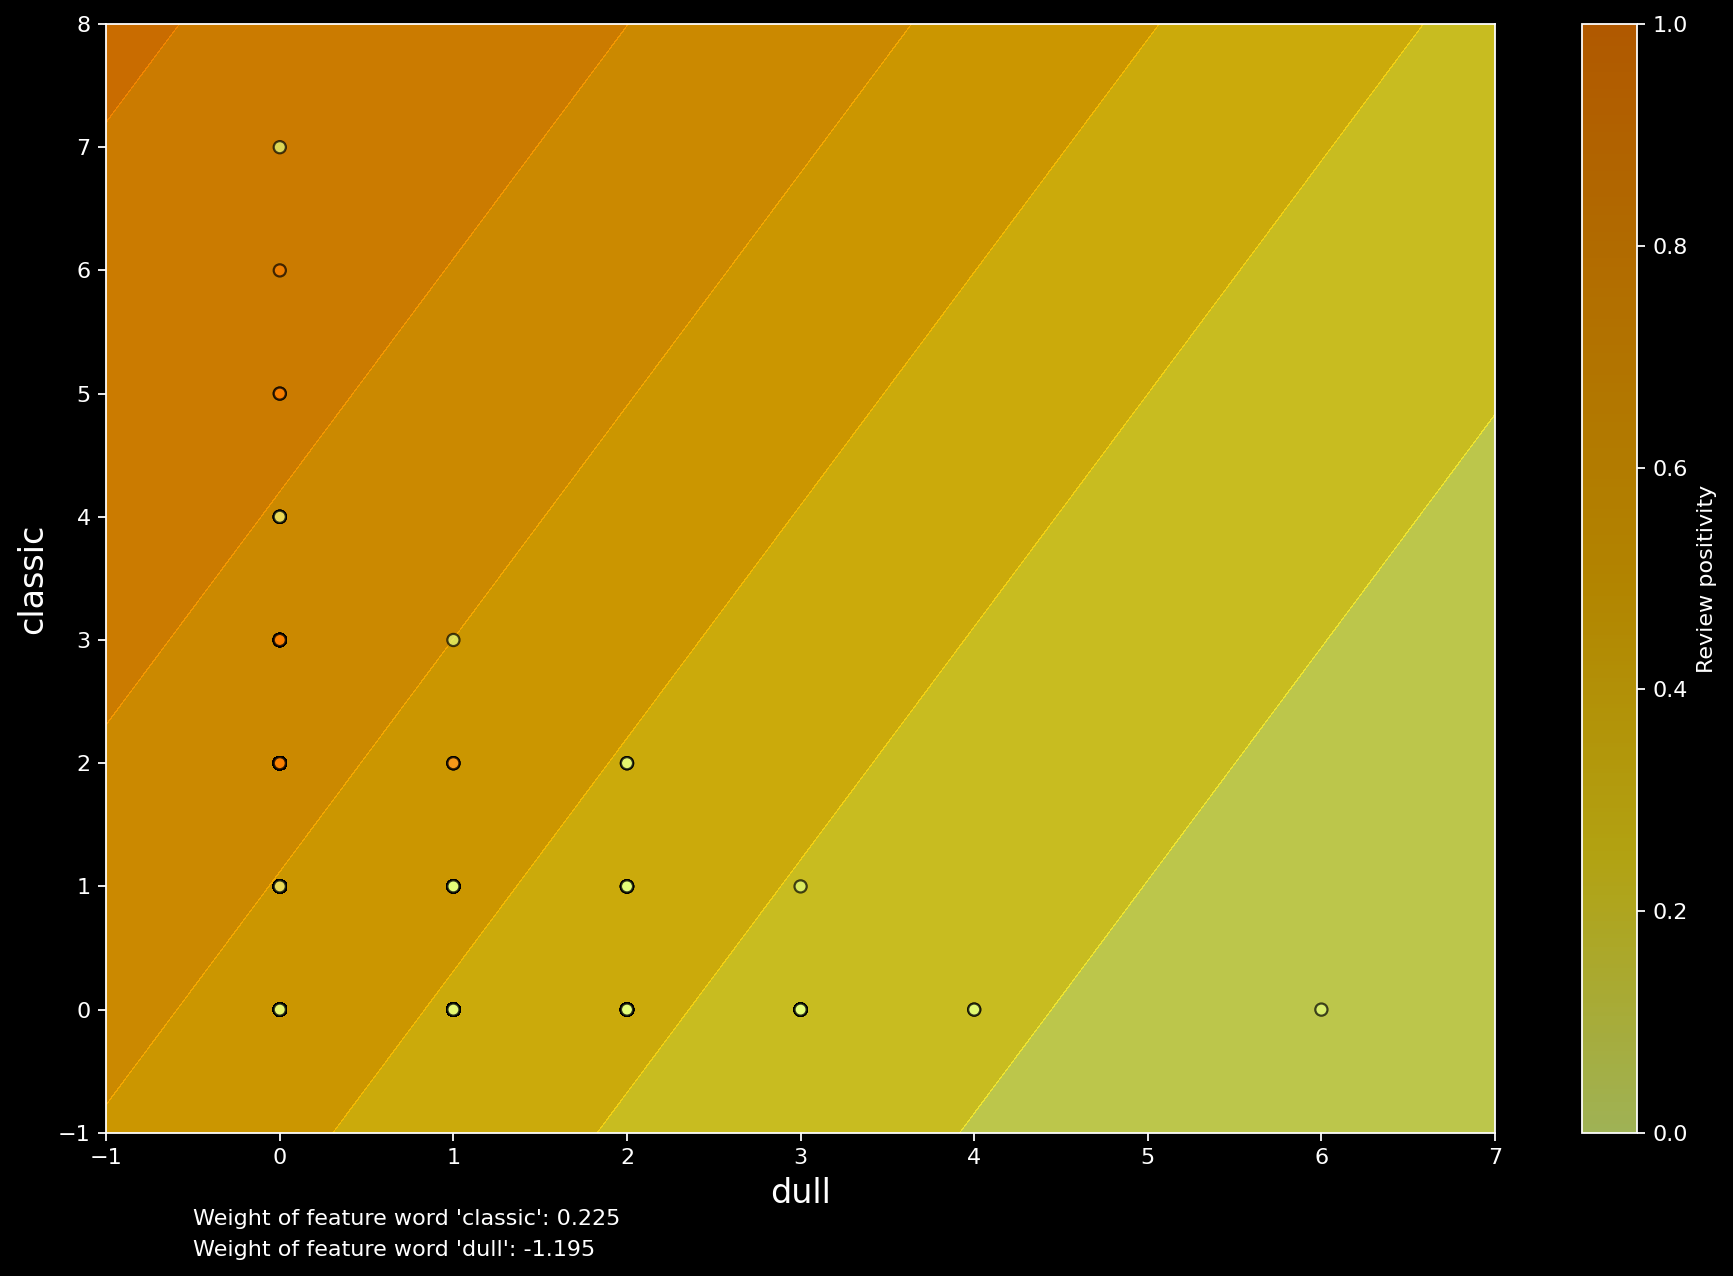

In [38]:
N, D = x_train.shape

x_feature_index = 75 # dull
y_feature_index = 48 # classic

x_min, x_max = min(x_train[:,x_feature_index])-1, max(x_train[:,x_feature_index]+1)
y_min, y_max = min(x_train[:,y_feature_index])-1, max(x_train[:,y_feature_index]+1)

x_all = np.linspace(x_min, x_max, 100)
y_all = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x_all, y_all)

input_all = np.zeros((N, D - 2))
input_all = np.zeros((10000, D - 2))
input_all = np.insert(input_all, x_feature_index, xx.ravel(), axis=1)
input_all = np.insert(input_all, y_feature_index, yy.ravel(), axis=1)

# Use previously fit model
y_proba = model.predict(scipy.sparse.csr_matrix(input_all))
z = y_proba.reshape(xx.shape)

plt.figure(num=1, figsize=(14, 9), dpi=160)
contour = plt.contourf(xx, yy, z, alpha=.8, cmap = 'Wistia')
plt.scatter(x_train[:, x_feature_index ], x_train[:, y_feature_index], edgecolor='k', c=y_train, s=30, cmap = 'Wistia', alpha=.7)
plt.xlabel(f"{x_train_df.columns[x_feature_index]}", fontsize=15)
plt.ylabel(f"{x_train_df.columns[y_feature_index]}", fontsize=15)
cbar = plt.colorbar()
cbar.set_label('Review positivity')
plt.text(-.5, -2, f"Weight of feature word '{x_train_df.columns[x_feature_index]}': {model.w[x_train_df.columns.to_list().index(x_train_df.columns[x_feature_index ])]:.3f}")
plt.text(-.5, -1.75, f"Weight of feature word '{x_train_df.columns[y_feature_index]}': {model.w[x_train_df.columns.to_list().index(x_train_df.columns[y_feature_index ])]:.3f}")
plt.show()

### AUROC Evaluation

An appropriate measure of accuracy of our model is the Reciever Operating Characteristic (ROC) curve, which is an illustration of the diagnostic ability of a given method, formulated the following way:

$$
    ROC = \frac{\text{true positive rate}}{\text{false positive rate}}
$$

Instead of measuring the ROC attained, we will look at the area under the ROC curve to evaluate our model and compare it with the performance of sklearn's implementation of the same model as well as kNN on the same data.

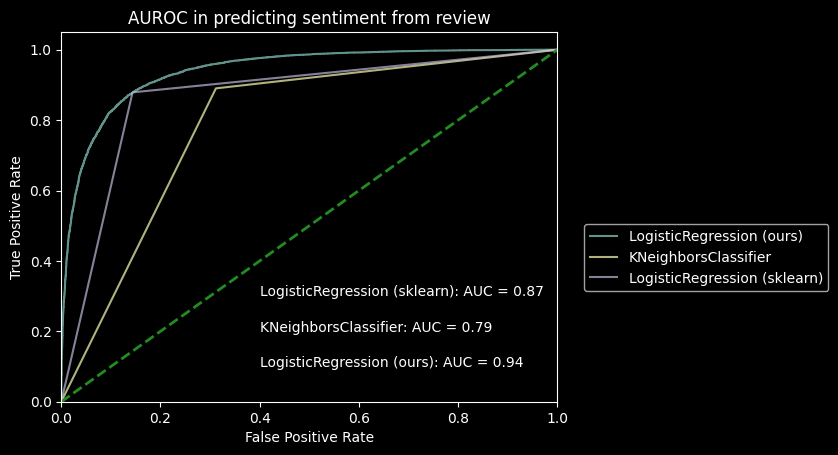

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

models = [KNeighborsClassifier(),
          sk_LogisticRegression(max_iter=1e5)]

perf = {}

# No need to re-fit our model
y_test_prob = model.predict(x_test_sparse)
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
auroc = roc_auc_score(y_test, y_test_prob)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for sklearn_model in models:
    fit = sklearn_model.fit(x_train, y_train)
    y_test_prob = sklearn_model.predict(x_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auroc = roc_auc_score(y_test, y_test_prob)
    if type(sklearn_model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(sklearn_model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name, alpha=0.7)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="forestgreen", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('AUROC in predicting sentiment from review')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
plt.show()

We can see that, comparing the AUROC of the different models, our model consistently outperforms sklearn's Logistic Regression as well as kNN implementation on diagnostic ability.

### Model Accuracy as a function of Training Data Size

Now let's examine our model's performence with respect to the sample data size (both train and test) and further compare it with that of kNN.

In [40]:
df_test

,acting,actually,adventure,also,although,always,amazing,annoying,any,anything,...,wouldn,write,wrong,yeah,years,young,your,zombies,ratings_numeric,ratings
0,1,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,2,1,0,8,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,1,0,2,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,8,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
4,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
24996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,1
24997,0,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,10,1
24998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [41]:
model_map = {}
model_map['Logistic Regression'] = dict()
model_map['kNN'] = dict()

tmp_df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)
y_test = tmp_df_test.loc[:,'ratings'].values.flatten()


for fraction in np.linspace(.1,1, 5):
    print(f"{(fraction * 100):.0f}%:")
    tmp_df_train = df_train.sample(frac=fraction, random_state=42).reset_index(drop=True)
    x_train_exp = tmp_df_train.iloc[:,:-2].to_numpy()
    x_test_exp = tmp_df_test.iloc[:,:-2].to_numpy()
    
    x_train_exp_sp = scipy.sparse.csr_matrix(x_train_exp)
    x_test_exp_sp = scipy.sparse.csr_matrix(x_test_exp)

    y_train_exp = tmp_df_train.loc[:,'ratings'].values.flatten()
    
    
    # sklearn kNN
    fit = sklearn_model.fit(x_train_exp, y_train_exp)
    y_prob = sklearn_model.predict(x_test_exp)
    
    y_pred = (y_prob > 0.5).astype(int)
    acc = sum(y_pred==y_test)/len(y_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auroc = roc_auc_score(y_test, y_prob)
    
    model_map['kNN'][fraction] = {'auroc': auroc, 'accuracy': acc}
    print(f"sklearn kNN auroc: {auroc:.3f}; accuracy: {acc:.3f}")
    
    
    # Logistic Regression
    model = LogisticRegression()
    model.fit(x_train_exp_sp, y_train_exp)
    y_prob = model.predict(x_test_exp_sp)
    
    y_pred = (y_prob > 0.5).astype(int)
    acc = sum(y_pred==y_test)/len(y_test)
        
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auroc = roc_auc_score(y_test, y_prob)
    
    model_map['Logistic Regression'][fraction] = {'auroc': auroc, 'accuracy': acc}
    print(f"Our Logistic model auroc: {auroc:.3f}; accuracy: {acc:.3f}")
    print()


10%:
sklearn kNN auroc: 0.836; accuracy: 0.836
Our Logistic model auroc: 0.902; accuracy: 0.826

32%:
sklearn kNN auroc: 0.859; accuracy: 0.859
Our Logistic model auroc: 0.932; accuracy: 0.858

55%:
sklearn kNN auroc: 0.862; accuracy: 0.862
Our Logistic model auroc: 0.936; accuracy: 0.862

78%:
sklearn kNN auroc: 0.865; accuracy: 0.865
Our Logistic model auroc: 0.938; accuracy: 0.865

100%:
sklearn kNN auroc: 0.868; accuracy: 0.868
Our Logistic model auroc: 0.939; accuracy: 0.867



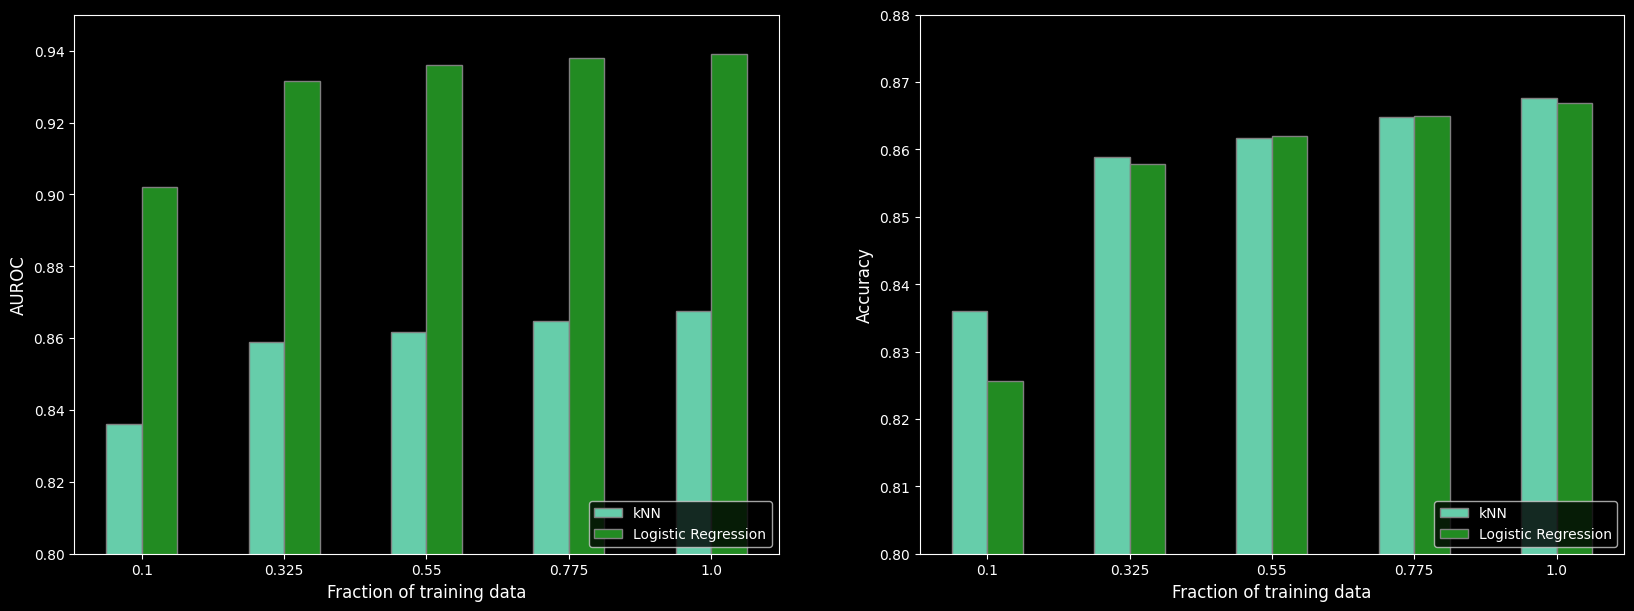

In [42]:
knn_AUROCS = [model_map['kNN'][fraction]['auroc'] for fraction in model_map['kNN'].keys()]
log_AUROCS = [model_map['Logistic Regression'][fraction]['auroc'] for fraction in model_map['kNN'].keys()]
knn_ACCS = [model_map['kNN'][fraction]['accuracy'] for fraction in model_map['kNN'].keys()]
log_ACCS = [model_map['Logistic Regression'][fraction]['accuracy'] for fraction in model_map['kNN'].keys()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
bar_width = .25
br1 = np.arange(len(knn_AUROCS))
br2 = [x + bar_width for x in br1]

ax1.bar(br1, knn_AUROCS, color ='mediumaquamarine', width = bar_width,edgecolor ='grey', label ='kNN')
ax1.bar(br2, log_AUROCS, color ='forestgreen', width = bar_width,edgecolor ='grey', label ='Logistic Regression')
ax1.set_xlabel('Fraction of training data', fontsize = 12)
ax1.set_ylabel('AUROC', fontsize = 12)
ax1.set_xticks([r + bar_width/2 for r in range(len(knn_AUROCS))],np.linspace(.1,1, 5))
ax1.legend(loc='lower right')
ax1.set_ylim(.8,.95)

ax2.bar(br1, knn_ACCS, color ='mediumaquamarine', width = bar_width,edgecolor ='grey', label ='kNN')
ax2.bar(br2, log_ACCS, color ='forestgreen', width = bar_width,edgecolor ='grey', label ='Logistic Regression')
ax2.set_xlabel('Fraction of training data', fontsize = 12)
ax2.set_ylabel('Accuracy', fontsize = 12)
ax2.set_xticks([r + bar_width/2 for r in range(len(knn_AUROCS))],np.linspace(.1,1, 5))
ax2.legend(loc='lower right')
ax2.set_ylim(.8,.88)

plt.show()


We see that our model consistently outperforms kNN in AUROC, whereas in accuracy they're more or less on par. This means that our model is decent in precise prediction, but quite favorable in diagnosis.

In addition, as expected, we see an increase in performance as the dataset gets larger. We attribute this to the fact that the more information we use to fit, the better are our predictions.

### Effect of Learning Rate on epochs

We're happy with our accuracy, but perhaps we can speed things up. So far we've used a default $\alpha = .6$, and the speed was quite satisfactory. Let's see what happens when we play around with different learning rates. Will an increase in learning rate speed things up? Will this speed come at the cost of a loss in accuracy? Let's find out.

In [44]:
learning_rates = np.linspace(.4, 1, 5)

times = []
iterations = []
AUROCS = []
ACCS = []

for alpha in learning_rates:
    start = time.time()

    model = LogisticRegression(learning_rate = alpha, max_iters = 50000)
    model.fit(x_train_sparse, y_train)

    y_train_prob = model.predict(x_train_sparse)
    fpr, tpr, _ = roc_curve(y_train, y_train_prob)
    auroc = roc_auc_score(y_train, y_train_prob)

    y_pred = (y_train_prob > 0.5).astype(int)
    acc = sum(y_pred==y_test)/len(y_test)
    
    end = time.time()

    print(f"Model fit with learning rate {alpha}")
    print(f"Time elapsed: {end - start}, iterations: {model.t}, AUROC: {auroc}, accuracy: {acc}")
    print()

    times.append(end - start)
    iterations.append(model.t/1000)
    AUROCS.append(auroc * 100)
    ACCS.append(acc * 100)

Model fit with learning rate 0.4
Time elapsed: 75.53716039657593, iterations: 22512, AUROC: 0.939057568, accuracy: 0.50452

Model fit with learning rate 0.55
Time elapsed: 54.142378091812134, iterations: 16372, AUROC: 0.9390575615999999, accuracy: 0.50452

Model fit with learning rate 0.7
Time elapsed: 42.38938593864441, iterations: 12864, AUROC: 0.9390575615999999, accuracy: 0.50452

Model fit with learning rate 0.85
Time elapsed: 35.076701164245605, iterations: 10594, AUROC: 0.939057568, accuracy: 0.50452

Model fit with learning rate 1.0
Time elapsed: 29.83927011489868, iterations: 9004, AUROC: 0.9390575744, accuracy: 0.50452



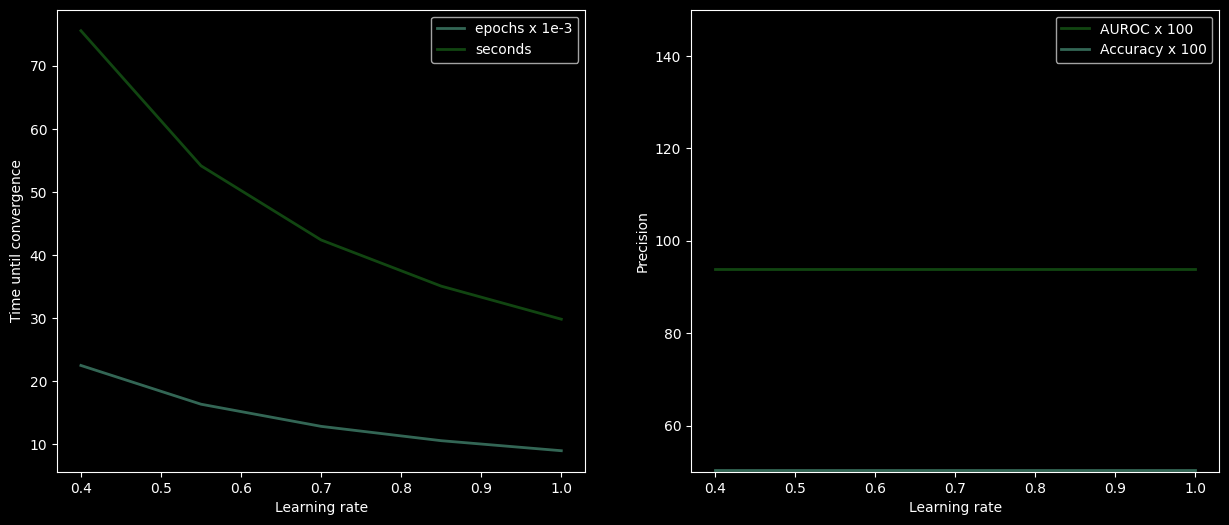

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(learning_rates, iterations, linewidth = 2, label="epochs x 1e-3", color = 'mediumaquamarine', alpha = 0.5)
ax1.plot(learning_rates, times, linewidth = 2,label="seconds", color = 'forestgreen', alpha = 0.5)
ax1.set_xlabel("Learning rate")
ax1.set_ylabel("Time until convergence")
ax1.legend(loc="upper right")

ax2.plot(learning_rates, AUROCS, linewidth = 2, label="AUROC x 100", color = 'forestgreen', alpha = 0.5)
ax2.plot(learning_rates, ACCS, linewidth = 2, label="Accuracy x 100", color = 'mediumaquamarine', alpha = 0.5)
ax2.set_xlabel("Learning rate")
ax2.set_ylabel("Precision")
ax2.legend(loc="upper right")
ax2.set_ylim(50,150)

plt.show()

We observe that a learning rate increase consistently reduces time until convergence, while our precision (AUROC and accuracy) remains constant.

# Linear Regression

Now let's implement linear regression to try and see if we can predict the exact ratings

As the review ratings are in $[1;3] \cup [7;10]$, if we guess if the review is positive or negative, we can reduce our prediction error to at most $2.25$ by choosing the middle point as our guess. In fact, the exact numerical bound for this strategy is 12.75 (assuming 85% accuracy in predicting if the review is good or bad, which is the accuracy of our logistic regression model), therefore we will aim to get a better result than that.

In [46]:
class Regression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]

        if self.add_bias:
            N = x.shape[0]
            x = np.c_[x, x, np.ones((N,1))]
        N,D = x.shape
        self.w = np.linalg.lstsq(x, y, rcond=None)[0]
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        N = x.shape[0]
        if self.add_bias:
            x = np.c_[x, x, np.ones((N,1))]
        yh = np.dot(x, self.w)
        return yh

For linear regression, we will use the standard squared loss as our cost function.

In [47]:
def squared_loss_fn(y, y_pred):
    return np.mean((y - y_pred)**2)

Now let's run some experiments:

In [48]:
regression_model = Regression(add_bias = True)
y_pred = regression_model.fit(x_train, y_train).predict(x_test)
loss_test = squared_loss_fn(y_test, y_pred)
print(f"Model fit with bias, total loss: {loss_test}")

Model fit with bias, total loss: 0.3645047726156607


In [49]:
regression_model = Regression(add_bias = False)
y_pred = regression_model.fit(x_train, y_train).predict(x_test)
loss_test = squared_loss_fn(y_test, y_pred)
print(f"Model fit without bias, total loss: {loss_test}")

Model fit without bias, total loss: 0.4338124110484955


The minimum least squared loss we get is 0.36 without bias, which means that every prediction we make is around $\pm\ 0.6$ off. This is certainly better than the threshold we initially had determined. 

### Conclusion

All in all we've seen that using a logistic regression model with the right feature selection and data pre-processing methods yields 86% accuracy which is comparable to that of sklearn's kNN and logistic regression, however our method has a much greater AUROC which outlines its superiour diagnostic ability.

Further, we've seen that we can also predict exact ratings using simple linear regression, with a squared loss of less than one. This high accuracy however might stem from the bias of using only IMDB reviews.

Further exploration could be done in generalizing the model by training and testing on text that isn't strictly IMDB reviews. Text such as Twitter and Reddit posts could be accumulated to see how the current model trained on IMDB reviews performs on sentiment prediction. Further, training could be done on this new dataset as well, however the issue of availability of high-quality, labelled data is the only obstacle.